# roAp Classification using regression techniques:
    ~ The classification uses a threshold value of 1.5 for all the regressions
### Updates:
* initial: (03/2/2023)
* linear regression: (04/4/2023)
* classification: (04/13/2023)
* polynomial regression classification: (04/18/22023)
* added lasso regression classification: (04/19/2023)
### Needed:
* add poly to generic and FOV plot w roAp and cluster, just to see what's up
* finish project off with adding elastic-net regression and possibly doing a learning curve
* logistic regression possibly??

In [28]:
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [2]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 122)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 91)


C:\Users\bowcr\AppData\Local\Temp\ipykernel_21312\1649100.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  all['designation'] = all['designation'].str.replace(r'\D', '')


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### ~ Plotting the initial HRD with the field roAps and NGC 2264

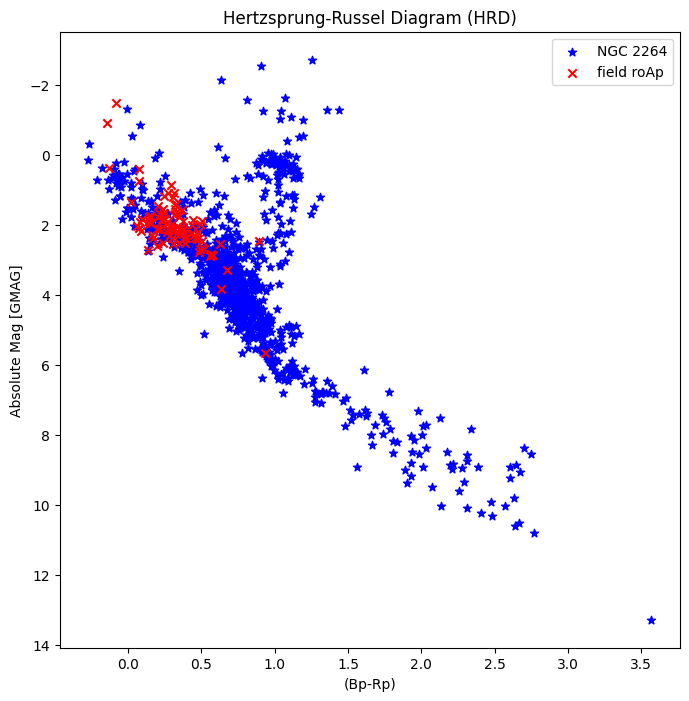

In [3]:
plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()

plt.scatter(x=xc,y=yc,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='x', c='r', label='field roAp')

plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.show()

----

### 2. Splitting the data to be used for training and showing the sizes

In [4]:
# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


----

### 3. Training the Linear Regression model and plotting with the HRD
        Do this but with polynomial, lets see what the cluster gives!

Coefficient for roAp or slope(m) in y = mx+b: [3.10297807]
Coefficient for cluster or slope(m) in y = mx+b: [3.02044125]

Mean squared error for roAp: 0.22
Mean squared error for cluster: 2.09

Coefficient of determination for roAp: 0.53
Coefficient of determination for cluster: 0.60


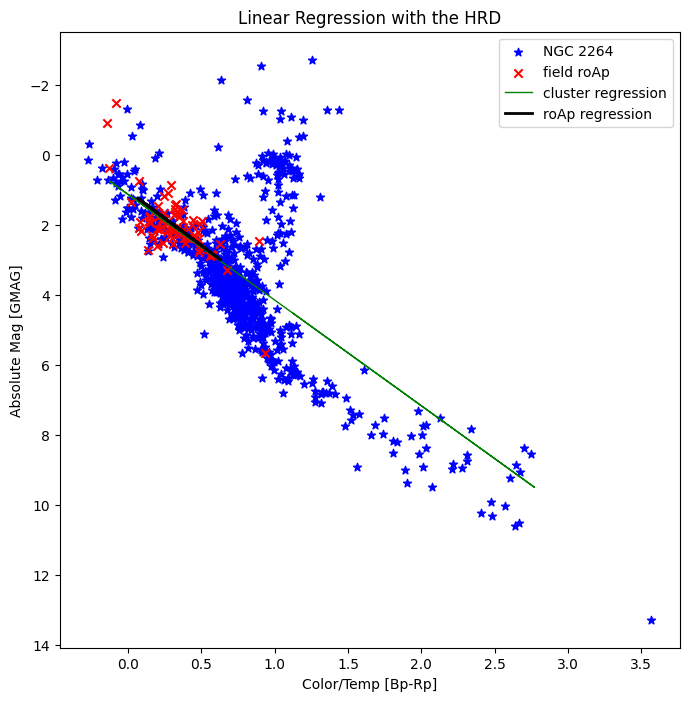

In [5]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()
plt.title('Linear Regression with the HRD')

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='x', c='r', label='field roAp')
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

----

### 4. Training and plotting the concatenated dataset with the linear regression

#### ~ The following shows the FOV we want to apply the regresion models to, with the cluster data:

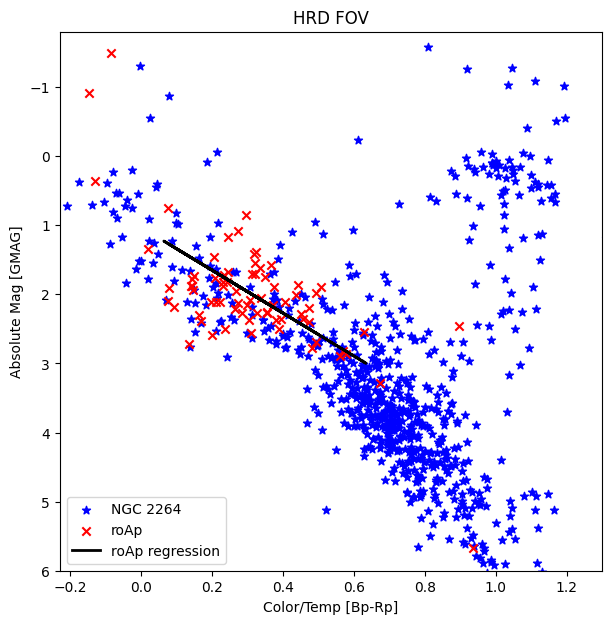

In [6]:
plt.figure(figsize=(7,7))
plt.title('HRD FOV')

plt.ylim([-1.8,6])
plt.xlim([-0.23,1.3])

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.gca().invert_yaxis()

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

#### ~ Fitting the roAp's regression to the concatenated dataset and finding the deviations:

In [7]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)
pred = regr.predict(xtrain)
predr = regr.predict(xtrain_r)

print("Regression Coefficient:", regr.coef_[0])
dist = np.abs(ytrain - pred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 3.1029780686728063
Length of the deviation list: 846


#### ~ Computing which cluster stars are potential candidates using the deviations, threshold value, and the maximum B-R value:

In [8]:
print('Stars in NGC 2264 following the Linear regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Linear regression:
Deviation: 1.3228301915967853 | ID: 130 | GMAG: 5.119092 | B-R:  0.8907399600868287
Deviation: 0.13923219406767795 | ID: 137 | GMAG: 0.694696 | B-R:  -0.06393440395164321
Deviation: 0.0927644823210394 | ID: 142 | GMAG: 2.461058 | B-R:  0.49033773403642444
Deviation: 1.4921822834708367 | ID: 161 | GMAG: 4.865949 | B-R:  0.754582023252051
Deviation: 1.2883972496950062 | ID: 162 | GMAG: 3.741228 | B-R:  0.4577910225286498
Deviation: 1.4651525527729685 | ID: 190 | GMAG: 4.917961 | B-R:  0.780054884789766
Deviation: 1.216958317958164 | ID: 197 | GMAG: 1.817156 | B-R:  -0.13925898145528387
Deviation: 1.3676070026610674 | ID: 203 | GMAG: 0.554031 | B-R:  0.2866029780475214
Deviation: 1.351628188649416 | ID: 241 | GMAG: 6.453708 | B-R:  1.311567298871691
Deviation: 0.5951397690839713 | ID: 282 | GMAG: 2.237352 | B-R:  0.5801447776556928
Deviation: 0.5464239917573805 | ID: 292 | GMAG: 2.499198 | B-R:  0.2966372112559015
Deviation: 1.31334647061

### 5. Exporting potential candidates

#### ~ Writing the data to a csv file:

In [9]:
print(len(cands))
df = pd.DataFrame(cands)
df.to_csv('Data/linear-candidates.csv',index=False,header=True)
df.describe()

47


,ID,Deviation,GMAG,B-R
count,47.000000,47.000000,47.000000,47.000000
mean,515.127660,0.944423,2.638157,0.395565
std,243.636902,0.415642,1.385572,0.368278
min,130.000000,0.051572,-0.228720,-0.315860
25%,301.000000,0.679131,1.902624,0.158695
50%,539.000000,1.014169,2.539740,0.370962
75%,705.500000,1.300199,2.999869,0.622381
max,933.000000,1.492182,6.609363,1.392616


#### ~ Displaying the candidates with the roAp's:

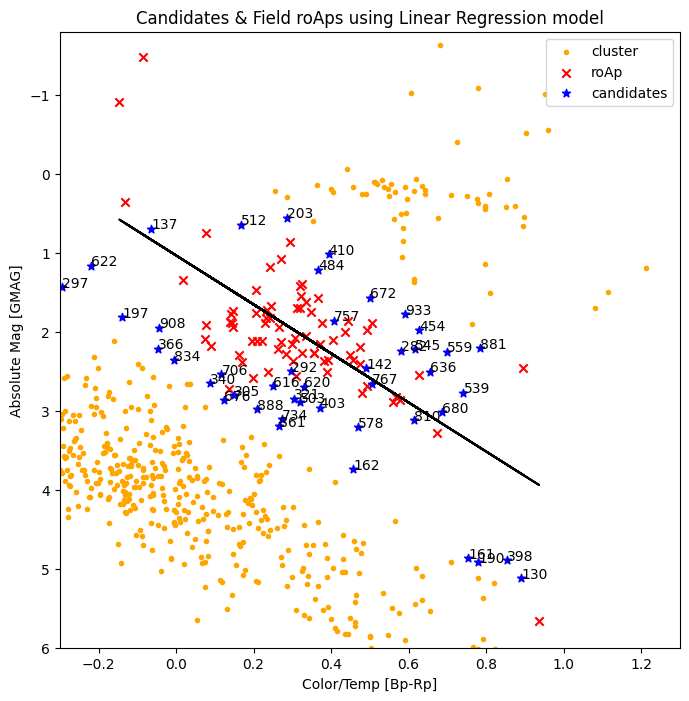

In [10]:
a1 = df['B-R']
b1 = df['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Linear Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a1,b1,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,predr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(df['ID']):
    plt.annotate(id, (a1[i],b1[i]))

plt.savefig('Figures/Linear-Candidates')
plt.show()

### 6. Showing which degree is best to fit to data for no under/over fitting

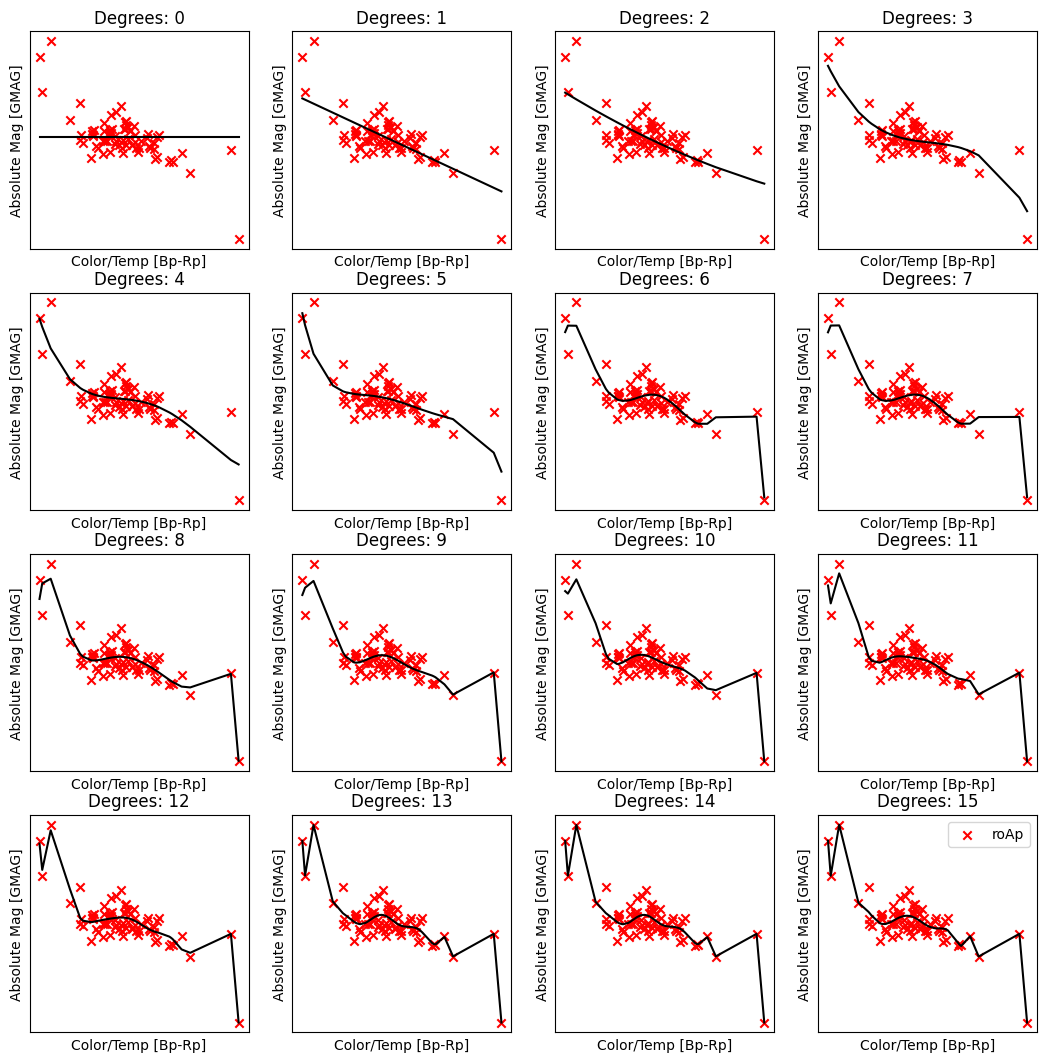

In [11]:
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
xarr = np.array(xs)

plt.figure(figsize=(13,13))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    polyi = PolynomialFeatures(degree=(i))
    regpi = LinearRegression()
    
    pfri = polyi.fit_transform(xtrain_r)
    pfi = polyi.fit_transform(xtrain)

    regpi.fit(pfri, ytrain_r)
    yfi = pd.Series(regpi.predict(pfri).flatten())
    ypredi = np.array(yfi[xs.index])

    plt.gca().invert_yaxis()
    plt.title(f'Degrees: {i}')
    plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
    plt.plot(xarr,ypredi,c='black')
    
    plt.ylabel('Absolute Mag [GMAG]')
    plt.xlabel('Color/Temp [Bp-Rp]')
    plt.savefig('Figures/ith-deg-Polynomial-roAp')
plt.legend()

### 7. Training and plottting the concatenated dataset using polynomial regression
        5 degrees being used, chosen from subplot

In [12]:
deg = 5
poly = PolynomialFeatures(degree=deg, include_bias=False)
regp = LinearRegression()

pfr = poly.fit_transform(xtrain_r)
pf = poly.fit_transform(xtrain)
regp.fit(pfr, ytrain_r)
print('')

#### ~ Predicting, calculating deviation, and exporting candidates then plotting

In [13]:
predp = regp.predict(pf)
predpr = regp.predict(pfr)

print(f'Intercept: {regp.intercept_} and Coefficients: {regp.coef_}')
print('The Mean Squared Error: %.2f' % mean_squared_error(ytrain,pred))
dist = np.abs(ytrain - predp)
print('Length of the deviation list:', len(dist))

Intercept: 1.3937684177467369 and Coefficients: [   7.08760245  -44.21950655  134.14830137 -172.50841119   80.35863064]
The Mean Squared Error: 10.85
Length of the deviation list: 846


In [14]:
print('Stars in NGC 2264 following the Polynomial regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Polynomial regression:
Deviation: 1.2266395142157496 | ID: 130 | GMAG: 5.119092 | B-R:  0.8907399600868287
Deviation: 0.027152410087130652 | ID: 137 | GMAG: 0.694696 | B-R:  -0.06393440395164321
Deviation: 0.10309154326462133 | ID: 142 | GMAG: 2.461058 | B-R:  0.49033773403642444
Deviation: 1.4607232784025141 | ID: 162 | GMAG: 3.741228 | B-R:  0.4577910225286498
Deviation: 1.0642739677780533 | ID: 176 | GMAG: 1.895467 | B-R:  0.7628811611847561
Deviation: 1.388377244768503 | ID: 203 | GMAG: 0.554031 | B-R:  0.2866029780475214
Deviation: 1.4433671038117615 | ID: 275 | GMAG: 2.684225 | B-R:  -0.019150128916945338
Deviation: 0.2692593707126587 | ID: 279 | GMAG: 6.105931 | B-R:  0.9864086937988245
Deviation: 1.47279995369302 | ID: 280 | GMAG: 3.334671 | B-R:  0.1942556499199824
Deviation: 0.31850390134439177 | ID: 282 | GMAG: 2.237352 | B-R:  0.5801447776556928
Deviation: 0.5435961765283917 | ID: 292 | GMAG: 2.499198 | B-R:  0.2966372112559015
Deviation: 0.9

In [15]:
print(len(cands))
dfp = pd.DataFrame(cands)
dfp.to_csv('Data/polynomial-candidates.csv',index=False,header=True)
dfp.describe()

50


,ID,Deviation,GMAG,B-R
count,50.000000,50.000000,50.000000,50.000000
mean,533.680000,0.876457,2.510213,0.379912
std,235.461894,0.412899,1.061287,0.277239
min,130.000000,0.027152,0.554031,-0.063934
25%,325.750000,0.574228,1.956387,0.154671
50%,543.500000,0.904476,2.652173,0.359966
75%,704.750000,1.211614,2.950457,0.613947
max,933.000000,1.472800,6.105931,0.986409


#### ~ Displaying graph of roAp candidates with field roAp's using 5 degree polynomial regression

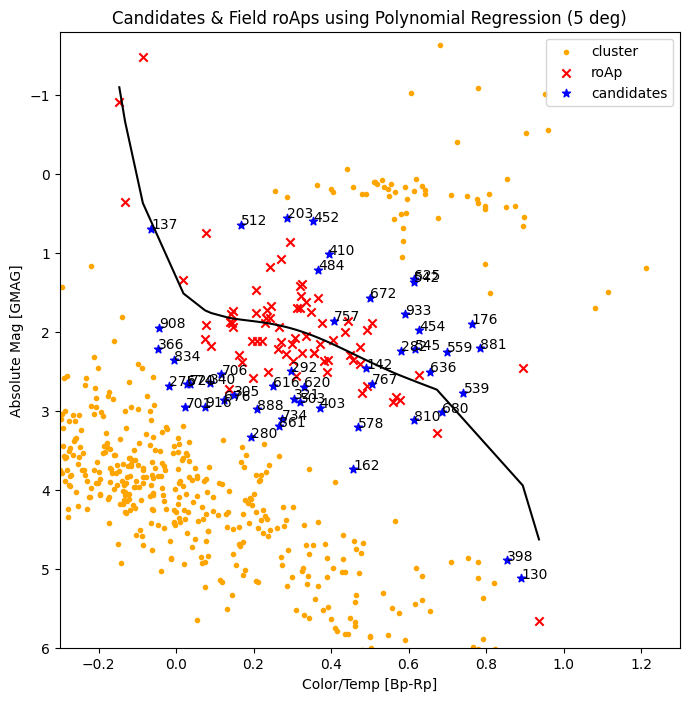

In [16]:
a2 = dfp['B-R']
b2 = dfp['GMAG']
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
yf = pd.Series(predpr.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
ypred = np.array(yf[xs.index])
xarr = np.array(xs)

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title(f'Candidates & Field roAps using Polynomial Regression ({deg} deg)')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a2,b2,marker='*',c='b',label='candidates')
plt.plot(xarr,ypred,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfp['ID']):
    plt.annotate(id, (a2[i],b2[i]))
    
plt.savefig(f'Figures/Polynomial-Candidates-{deg}deg')
plt.show()

### 8. Training and plotting concatenated set with Lasso regression

In [17]:
lreg = Lasso(alpha=.06)

lreg.fit(xtrain_r,ytrain_r)
lpred = lreg.predict(xtrain)
lpredr = lreg.predict(xtrain_r)

print("Regression Coefficient:", lreg.coef_[0])
dist = np.abs(ytrain - lpred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.429106970904034
Length of the deviation list: 846


#### ~ The slope, coefficient, is very steep, as seen in the plot. This is a discrete value, determined from $\alpha$, here it is 0.06

In [18]:
print('Stars in NGC 2264 following the Lasso regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Lasso regression:
Deviation: 1.3973750588656522 | ID: 93 | GMAG: 1.697933 | B-R:  1.08238812552992
Deviation: 0.7623945410792052 | ID: 137 | GMAG: 0.694696 | B-R:  -0.06393440395164321
Deviation: 0.2118532827441646 | ID: 142 | GMAG: 2.461058 | B-R:  0.49033773403642444
Deviation: 1.4564292996767019 | ID: 146 | GMAG: 2.707316 | B-R:  -0.20822300162426202
Deviation: 0.7432314288675919 | ID: 176 | GMAG: 1.895467 | B-R:  0.7628811611847561
Deviation: 0.4677123377116488 | ID: 197 | GMAG: 1.817156 | B-R:  -0.13925898145528387
Deviation: 1.4040149572566616 | ID: 203 | GMAG: 0.554031 | B-R:  0.2866029780475214
Deviation: 1.3311134902472803 | ID: 228 | GMAG: 1.049143 | B-R:  0.5820395979693556
Deviation: 1.107779939175988 | ID: 261 | GMAG: 2.572694 | B-R:  -0.05845999237568001
Deviation: 1.1631329392818246 | ID: 275 | GMAG: 2.684225 | B-R:  -0.019150128916945338
Deviation: 0.1401965893284145 | ID: 282 | GMAG: 2.237352 | B-R:  0.5801447776556928
Deviation: 0.52681

In [19]:
print(len(cands))
dfl = pd.DataFrame(cands)
dfl.to_csv('Data/lasso-candidates.csv',index=False,header=True)
dfl.describe()

63


,ID,Deviation,GMAG,B-R
count,63.000000,63.000000,63.000000,63.000000
mean,553.936508,0.894405,2.269690,0.250950
std,239.967059,0.402692,0.703087,0.332205
min,93.000000,0.022259,0.554031,-0.235674
25%,349.500000,0.642281,1.876297,-0.051750
50%,571.000000,0.992859,2.499198,0.266458
75%,727.000000,1.180960,2.766284,0.543192
max,933.000000,1.462886,3.210998,1.082388


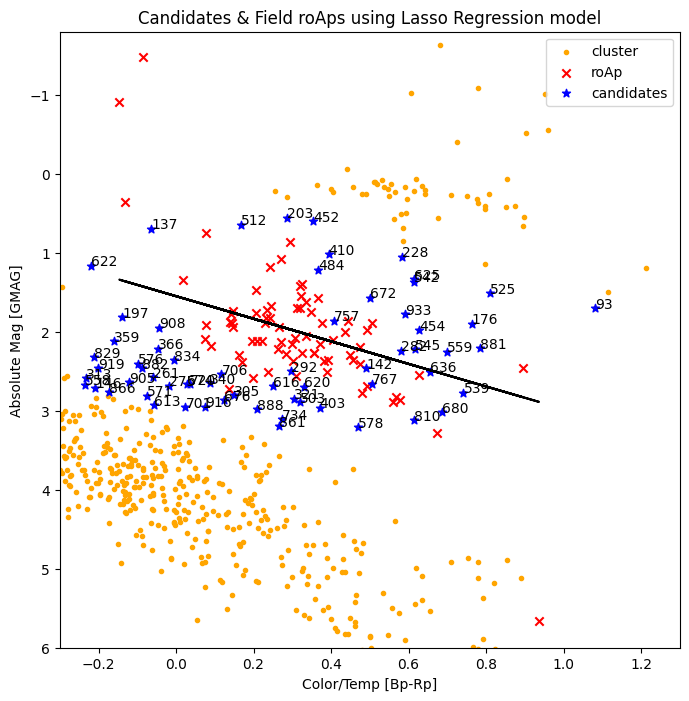

In [20]:
a3 = dfl['B-R']
b3 = dfl['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Lasso Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a3,b3,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfl['ID']):
    plt.annotate(id, (a3[i],b3[i]))
    
plt.savefig('Figures/Lasso-Candidates')
plt.show()

### 9. Elastic Net Regression

In [21]:
ereg = ElasticNet(alpha=.06)

ereg.fit(xtrain_r,ytrain_r)
epred = ereg.predict(xtrain)
epredr = ereg.predict(xtrain_r)

print("Regression Coefficient:", ereg.coef_[0])
dist = np.abs(ytrain - epred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.2335993612648197
Length of the deviation list: 846


In [22]:
print('Stars in NGC 2264 following the Elastic Net regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Elastic Net regression:
Deviation: 1.2460454443642233 | ID: 93 | GMAG: 1.697933 | B-R:  1.08238812552992
Deviation: 1.4858516312844592 | ID: 107 | GMAG: 1.498325 | B-R:  1.1149742212936369
Deviation: 0.8351797041922948 | ID: 137 | GMAG: 0.694696 | B-R:  -0.06393440395164321
Deviation: 0.24743254041873897 | ID: 142 | GMAG: 2.461058 | B-R:  0.49033773403642444
Deviation: 1.3554346177344443 | ID: 146 | GMAG: 2.707316 | B-R:  -0.20822300162426202
Deviation: 0.654367857228368 | ID: 176 | GMAG: 1.895467 | B-R:  0.7628811611847561
Deviation: 0.38020064650373886 | ID: 197 | GMAG: 1.817156 | B-R:  -0.13925898145528387
Deviation: 1.4082673947259061 | ID: 203 | GMAG: 0.554031 | B-R:  0.2866029780475214
Deviation: 1.4243199539328641 | ID: 223 | GMAG: 2.814915 | B-R:  -0.17684031368100067
Deviation: 1.2776058203557183 | ID: 228 | GMAG: 1.049143 | B-R:  0.5820395979693556
Deviation: 1.0360650651842962 | ID: 261 | GMAG: 2.572694 | B-R:  -0.05845999237568001
Deviation: 

In [23]:
print(len(cands))
dfe = pd.DataFrame(cands)
dfe.to_csv('Data/elastic-net-candidates.csv',index=False,header=True)
dfe.describe()

73


,ID,Deviation,GMAG,B-R
count,73.000000,73.000000,73.000000,73.000000
mean,540.876712,0.941788,2.290934,0.242101
std,239.361416,0.412167,0.727435,0.351923
min,93.000000,0.087059,0.554031,-0.235674
25%,340.000000,0.662162,1.857126,-0.067017
50%,558.000000,1.008435,2.539740,0.209944
75%,720.000000,1.277606,2.835936,0.580145
max,933.000000,1.486292,3.334671,1.114974


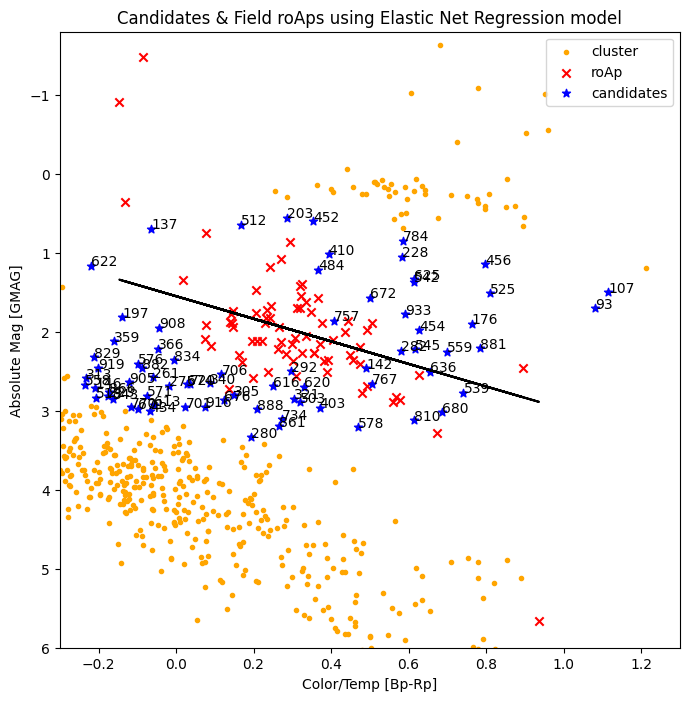

In [24]:
a4 = dfe['B-R']
b4 = dfe['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Elastic Net Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a4,b4,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfe['ID']):
    plt.annotate(id, (a4[i],b4[i]))
    
plt.savefig('Figures/Elastic-Net-Candidates')
plt.show()

### 10. Plotting and exporting all 3 regression model candidates, so we have new and repeated stars
        Still need to export the repeated and new stars; possibly a csv file for each, new, both, and all

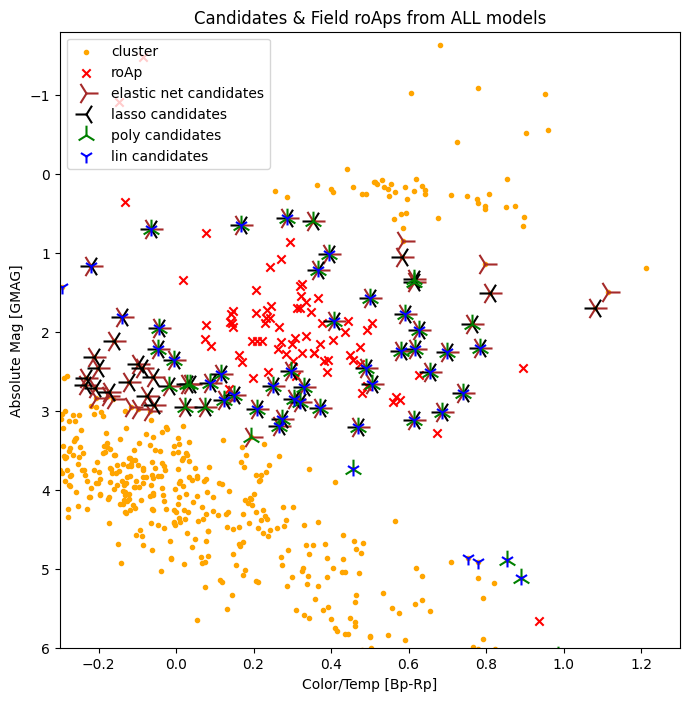

In [25]:
plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])
plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps from ALL models')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a4,b4,marker='4',s=300,c='brown',label='elastic net candidates')
plt.scatter(a3,b3,marker='3',s=250,c='black',label='lasso candidates')
plt.scatter(a2,b2,marker='2',s=200,c='g',label='poly candidates')
plt.scatter(a1,b1,marker='1',s=100,c='b',label='lin candidates')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()
    
plt.savefig('Figures/ALL-reg-Candidates')
plt.show()

In [34]:
#exporting new candidates to a CSV
# linear = df, poly = dfp, lasso = dfl, elasticnet = dfe
lin = df['ID']
poly = dfp['ID']
lasso = dfl['ID']
elasticnet = dfe['ID']

candidates = pd.DataFrame()

#singles
candidates['Linear'] = lin
candidates['Polynomial'] = poly
candidates['Lasso'] = lasso
candidates['Elastic Net'] = lasso

#combinations of two
lin_poly = pd.Series(np.intersect1d(lin,poly))
candidates['Linear - Polynomial'] = lin_poly

lin_lasso = pd.Series(np.intersect1d(lin,lasso))
candidates['Linear - Lasso'] = lin_lasso

lin_elastic = pd.Series(np.intersect1d(lin,elasticnet))
candidates['Linear - Elastic'] = lin_elastic

poly_lasso = pd.Series(np.intersect1d(poly,lasso))
candidates['Polynomial - Lasso'] = poly_lasso

poly_elastic = pd.Series(np.intersect1d(poly,elasticnet))
candidates['Polynomial - Elastic Net'] = poly_elastic

lasso_elastic = pd.Series(np.intersect1d(lasso,elasticnet))
candidates['Lasso - Elastic Net'] = lasso_elastic

#combinations of three
lin_poly_lasso = pd.Series(reduce(np.intersect1d, (lin, poly, lasso)))
candidates['Linear - Polynomial - Lasso'] = lin_poly_lasso

lin_poly_elastic = pd.Series(reduce(np.intersect1d, (lin, poly, elasticnet)))
candidates['Linear - Polynomial - Elastic Net'] = lin_poly_elastic

poly_lasso_elastic = pd.Series(reduce(np.intersect1d, (poly, lasso, elasticnet)))
candidates['Polynomial - Lasso - Elastic Net'] = poly_lasso_elastic

lin_lasso_elastic = pd.Series(reduce(np.intersect1d, (lin, lasso, elasticnet)))
candidates['Linear - Lasso - Elastic Net'] = lin_lasso_elastic

# candidates from all four
allfour = pd.Series(reduce(np.intersect1d, (lin, poly, lasso, elasticnet)))
candidates['All Four'] = allfour


candidates.to_csv('Data/total-candidates.csv',index=False,header=True)